In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py
from tqdm import tqdm, trange
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    sys.path.append(r'C:\_Lib\python')
    from BEMHelper import interpolate_slow
    from slab.circuitqed import SingleElectron
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis, single_electron as se
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
# %config InlineBackend.figure_format='retina'

Warning serial library import failed.
Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'


C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick
Warning no qutip!


# Two-tone drive strength estimate

In [27]:
def Pe(omega, T1, T2, delta):
    return 0.5 * omega ** 2 * T1 * T2 / (omega ** 2 * T1 * T2 + 1 + delta ** 2 * T2 ** 2)

In [28]:
ns_estimate = common.get_noof_photons_in_cavity(0 - 60 - 72, 6.405E9, 15000)
print(ns_estimate)

5.539120264020722


In [72]:
T2 = 1/100E6
T1 = 1/10E6
delta = 2*np.pi*np.linspace(-.5E9, .5E9, 1E3)
ns = np.logspace(-2, 2)
coupling = 2 * np.pi * 5E6
omega = 2 * np.sqrt(ns) * coupling

C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


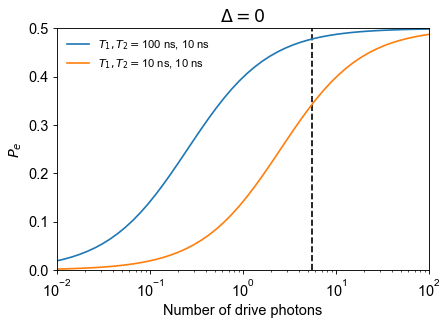

In [73]:
fig = plt.figure(figsize=(6.,4.))
common.configure_axes(13)

for T1 in [1/10E6, 1/100E6]:
    plt.plot(ns, Pe(omega, T1, T2, 0), label='$T_1, T_2 = $%.0f ns, %.0f ns'%(T1 * 1e9, T2 * 1e9))

plt.vlines(ns_estimate, 0, 0.50, linestyles='--', color='k')
plt.xscale('log')
plt.xlabel("Number of drive photons")
plt.ylabel("$P_e$")
plt.xlim(np.min(ns), np.max(ns))
plt.ylim(0, 0.5)
plt.title(r"$\Delta = 0$")

plt.legend(loc=0, frameon=False, prop={"size" : 10})

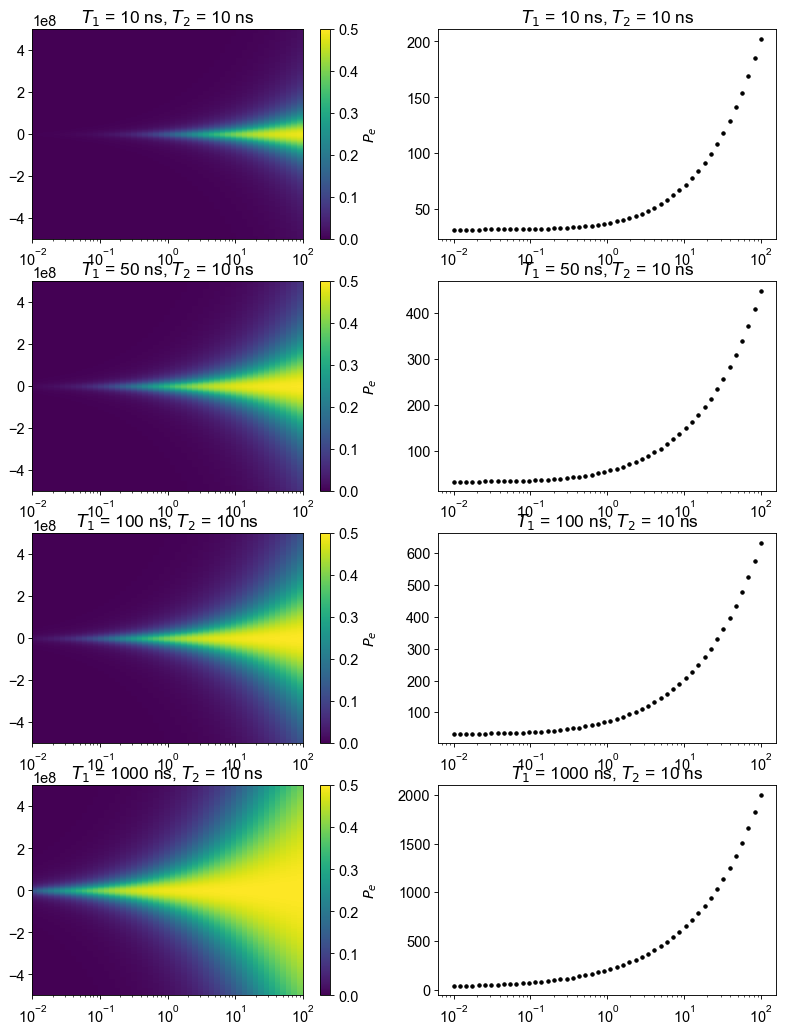

In [74]:
fig = plt.figure(figsize=(12.,16.))
T1s = [10E-9, 50E-9, 100E-9, 1000E-9]
for kk, T1 in enumerate(T1s):
    pe_array = np.zeros((len(delta), len(ns)))
    qubit_width = list()
    
    for jj, d in enumerate(delta):
        pe_array[jj, :] = Pe(omega, T1, T2, d)
    
    for ll, n in enumerate(ns):
        fr, ferr = kfit.fit_lor(delta/(2*np.pi), pe_array[:, ll], 
                                parambounds=([-np.inf, -np.inf, -np.inf, 0], 
                                             [+np.inf, np.inf, np.inf, np.inf]), 
                                verbose=False)
        qubit_width.append(2*fr[3])
        
    plt.subplot(4, 2, 2*kk+1)
    plt.pcolormesh(ns, delta/(2*np.pi), pe_array, vmin=0, vmax=0.5)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("$P_e$")
    plt.xscale('log')
    plt.title("$T_1$ = %.0f ns, $T_2$ = %.0f ns"%(T1 * 1E9, T2*1E9))
    
    plt.subplot(4, 2, 2*kk+2)
    plt.plot(ns, np.array(qubit_width) / (1E6), '.k')
    plt.xscale('log')
    plt.title("$T_1$ = %.0f ns, $T_2$ = %.0f ns"%(T1 * 1E9, T2*1E9))